In [16]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
#from tensorflow.python.keras.layers.normalization import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical

In [17]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/My Drive

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [18]:
root_path = "/content/gdrive/My Drive/CNN_assignment/Skin_cancer"
data_dir_train = pathlib.Path(root_path + '/Train')
data_dir_test = pathlib.Path(root_path + '/Test')

In [19]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


In [21]:
#Creating a dataset
#80% of the images for training and 20% for validation.
batch_size = 32
img_height = 180
img_width = 180

In [22]:
##writing training dataset here and using seed=123. Also, resizing images to the size img_height*img_width

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [23]:
##writing validation dataset here and using seed=123. Also, resizing images to the size img_height*img_width
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [24]:
##writing test dataset here and using seed=123. Also, resizing images to the size img_height*img_width
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [25]:
# List out all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


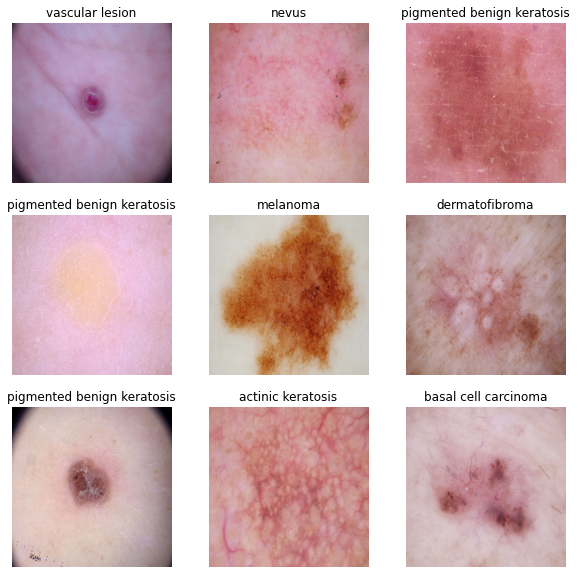

In [26]:
#Visualizing the data

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [27]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [28]:
#Creating the model

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [29]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 180, 180, 32)      2432      
                                                                 
 conv2d_6 (Conv2D)           (None, 180, 180, 32)      25632     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 90, 90, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 45, 45, 32)       0         
 2D)                                                  

In [31]:
#Training the model
epochs = 30
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 45s 658ms/step - loss: 2.0533 - accuracy: 0.1992 - val_loss: 2.0528 - val_accuracy: 0.1499
Epoch 2/30
56/56 [==============================] - 3s 47ms/step - loss: 2.0320 - accuracy: 0.1897 - val_loss: 2.0277 - val_accuracy: 0.1924
Epoch 3/30
56/56 [==============================] - 3s 47ms/step - loss: 2.0221 - accuracy: 0.1981 - val_loss: 1.9853 - val_accuracy: 0.2103
Epoch 4/30
56/56 [==============================] - 3s 46ms/step - loss: 1.9817 - accuracy: 0.2316 - val_loss: 1.9791 - val_accuracy: 0.2416
Epoch 5/30
56/56 [==============================] - 3s 47ms/step - loss: 1.9705 - accuracy: 0.2533 - val_loss: 2.0014 - val_accuracy: 0.2125
Epoch 6/30
56/56 [==============================] - 3s 47ms/step - loss: 1.9633 - accuracy: 0.2305 - val_loss: 1.9894 - val_accuracy: 0.2371
Epoch 7/30
56/56 [==============================] - 3s 47ms/step - loss: 1.9555 - accuracy: 0.2416 - val_loss: 1.9525 - val_accuracy: 0.2550
Epoch 8/30
56/56 [====

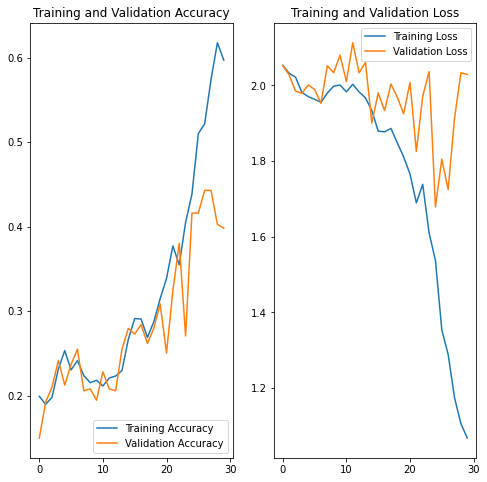

In [32]:
#Visualizing training results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- The model is overfitting because we can also see difference in loss functions in training & test around the 10-11th epoch

- The accuracy is just around 75-80% because there are enough features to remember the pattern.

- But again, it's too early to comment on the overfitting & underfitting debate

In [33]:
loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)


14/14 [==============================] - 0s 15ms/step - loss: 2.0290 - accuracy: 0.3982
Accuracy:  0.6729910969734192
Validation Accuracy:  0.3982102870941162
Loss:  0.9487994313240051
Validation Loss 2.028956651687622


In [34]:
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomRotation(0.2, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

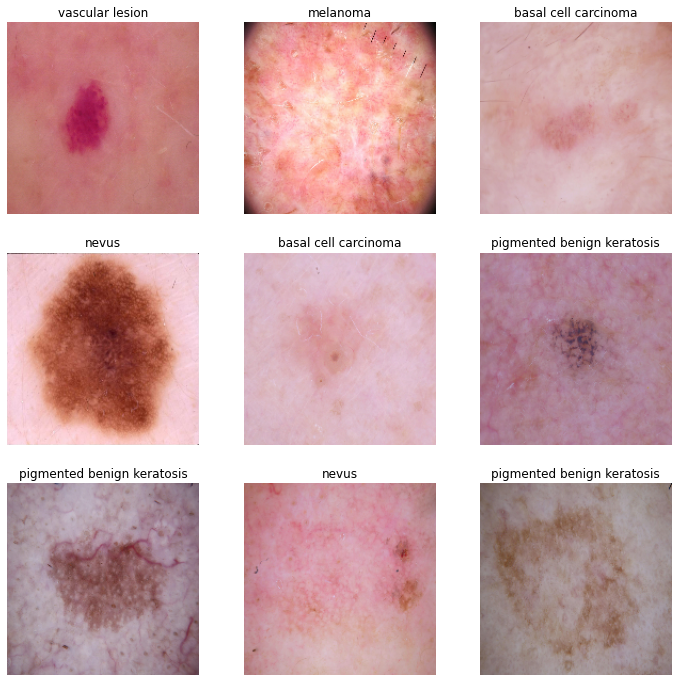

In [35]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [36]:
#Create, compile and train the model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = Sequential([ data_augument,
                    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width,3))
      
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', 
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

In [37]:
#Compiling the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [38]:
#Training the model
epochs = 30
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


56/56 [==============================] - 6s 61ms/step - loss: 2.0720 - accuracy: 0.2026 - val_loss: 2.0176 - val_accuracy: 0.1924
Epoch 2/30
56/56 [==============================] - 3s 53ms/step - loss: 1.9507 - accuracy: 0.2578 - val_loss: 1.8118 - val_accuracy: 0.3669
Epoch 3/30
56/56 [==============================] - 3s 54ms/step - loss: 1.8414 - accuracy: 0.3125 - val_loss: 1.8843 - val_accuracy: 0.3445
Epoch 4/30
56/56 [==============================] - 3s 54ms/step - loss: 1.7131 - accuracy: 0.3761 - val_loss: 1.5943 - val_accuracy: 0.4340
Epoch 5/30
56/56 [==============================] - 3s 55ms/step - loss: 1.6318 - accuracy: 0.4141 - val_loss: 1.5842 - val_accuracy: 0.4676
Epoch 6/30
56/56 [==============================] - 3s 54ms/step - loss: 1.5517 - accuracy: 0.4581 - val_loss: 1.5214 - val_accuracy: 0.4586
Epoch 7/30
56/56 [==============================] - 3s 53ms/step - loss: 1.6379 - accuracy: 0.4074 - val_loss: 1.5052 - val_accuracy: 0.4720
Epoch 8/30
56/56 [======

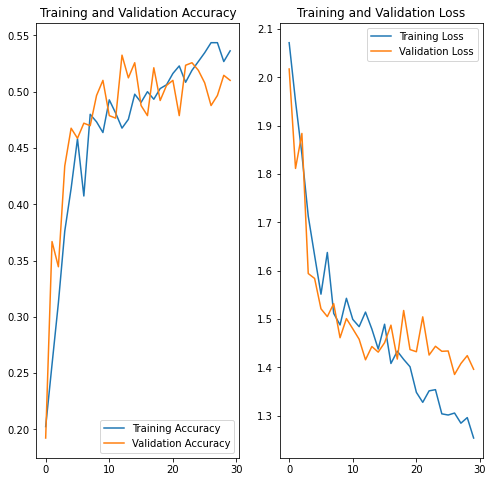

In [39]:
#Visualizing the results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

- There is no improvement in accuracy but we can definitely see the overfitting problem has solved due to data augmentation

- We can increase the epochs to increase the accuracy so it's too early for judgement

Todo: Find the distribution of classes in the training dataset.

Context: Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [40]:
path_list=[]
lesion_list=[]
for i in class_names:
      
    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
1,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
2,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
3,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
4,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2235,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2236,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2237,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion


In [41]:
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
1,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
2,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
3,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
4,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
...,...,...
2234,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2235,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2236,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
2237,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion


<BarContainer object of 9 artists>

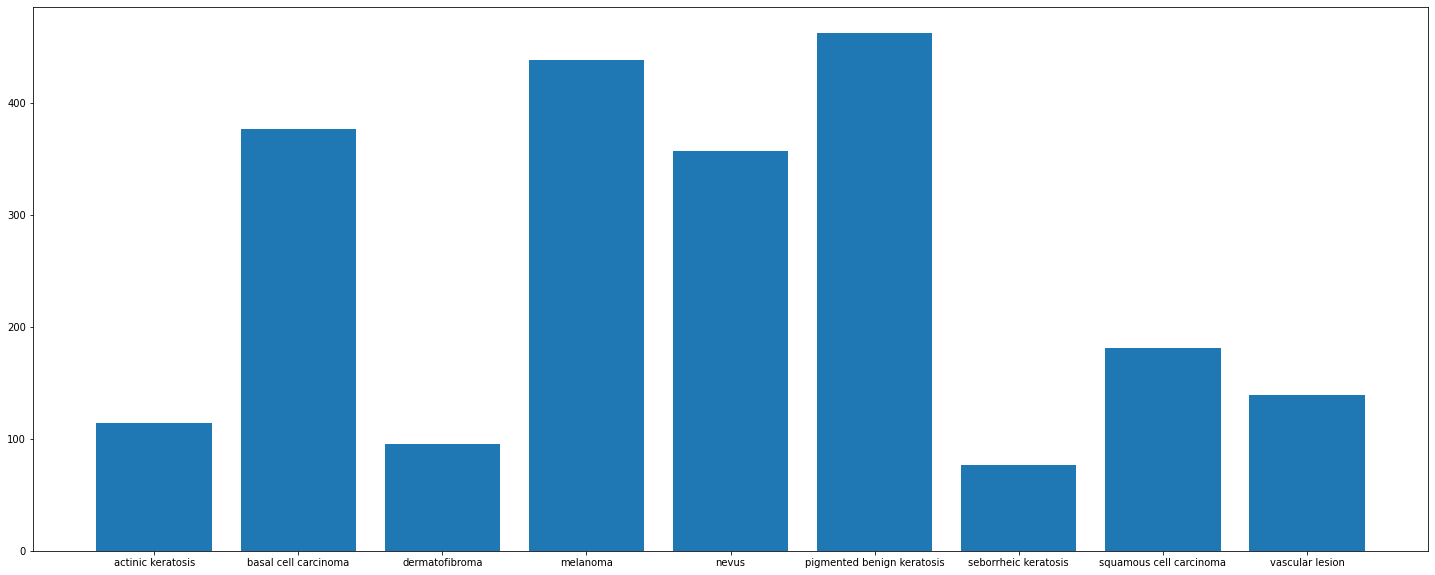

In [42]:
count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(25,10))
plt.bar(class_names,count)

- Which class has the least number of samples?

Answer-1 :- squamous cell carcinoma has least number of samples

- Which classes dominate the data in terms proportionate number of samples?

Answer-2:- actinic keratosis and dermatofibroma have proportionate number of classes. melanoma and pigmented benign keratosis have proprtionate number of classes

In [ ]:
class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'output',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [43]:
#Rectify the class imbalance
!pip install Augmentor

In [44]:
#path_to_training_dataset="/content/drive/MyDrive/Cancer Detection /Train"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train",save_format='jpg')
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F61CC331410>: 100%|██████████| 500/500 [00:27<00:00, 18.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F61CC3C3ED0>: 100%|██████████| 500/500 [00:25<00:00, 19.64 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F61CC367B10>: 100%|██████████| 500/500 [00:28<00:00, 17.72 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61CC42B710>: 100%|██████████| 500/500 [00:24<00:00, 20.05 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61CD931550>: 100%|██████████| 500/500 [00:24<00:00, 20.31 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F61CDBD8810>: 100%|██████████| 500/500 [00:23<00:00, 20.95 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F626014ECD0>: 100%|██████████| 500/500 [00:22<00:00, 21.92 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F61D26EEB90>: 100%|██████████| 500/500 [00:21<00:00, 22.73 Samples/s] 


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F626014EAD0>: 100%|██████████| 500/500 [00:23<00:00, 21.57 Samples/s] 


In [46]:
data_dir_train1 = pathlib.Path("/content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


In [47]:
for i in class_names:
      
    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
1,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
2,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
3,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
4,/content/gdrive/My Drive/CNN_assignment/Skin_c...,actinic keratosis
...,...,...
6734,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
6735,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
6736,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion
6737,/content/gdrive/My Drive/CNN_assignment/Skin_c...,vascular lesion


In [48]:
#Lets see the distribution of augmented data after adding new images to the original training data.
new_df['Label'].value_counts()

pigmented benign keratosis    1399
melanoma                      1344
basal cell carcinoma          1136
nevus                         1037
squamous cell carcinoma        504
vascular lesion                483
actinic keratosis              327
dermatofibroma                 280
seborrheic keratosis           229
Name: Label, dtype: int64

In [49]:
#Train the model on the data created using Augmentor
batch_size = 32
img_height = 180
img_width = 180

In [63]:
##Create a training dataset

data_dir_train1="/content/gdrive/My Drive/CNN_assignment/Skin_cancer/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 5392 files for training.


In [64]:
##Create a validation dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


In [65]:
###Create your model (make sure to include normalization)
input_shape = (180,180,3)
model = Sequential()

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 180, 180, 32)      896       
                                                                 
 conv2d_19 (Conv2D)          (None, 180, 180, 32)      9248      
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 90, 90, 32)       0         
 g2D)                                                            
                                                                 
 batch_normalization (BatchN  (None, 90, 90, 32)       128       
 ormalization)                                                   
                                                                 
 dropout_4 (Dropout)         (None, 90, 90, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 90, 90, 64)       

In [66]:
###Compile your model (Choose optimizer and loss function appropriately)

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In [67]:
## Training the model

epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
169/169 [==============================] - 28s 150ms/step - loss: 0.0000e+00 - accuracy: 0.0577 - val_loss: 0.0000e+00 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 2/50
169/169 [==============================] - 25s 146ms/step - loss: 0.0000e+00 - accuracy: 0.0577 - val_loss: 0.0000e+00 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 3/50
169/169 [==============================] - 25s 144ms/step - loss: 0.0000e+00 - accuracy: 0.0577 - val_loss: 0.0000e+00 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 4/50
169/169 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.0577
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
169/169 [==============================] - 25s 144ms/step - loss: 0.0000e+00 - accuracy: 0.0577 - val_loss: 0.0000e+00 - val_accuracy: 0.0483 - lr: 0.0010
Epoch 5/50
169/169 [==============================] - 25s 144ms/step - loss: 0.0000e+00 - accuracy: 0.0577 - val_loss: 0.0000e+00 - val_accuracy: 0.0483 - lr: 5.0000e-04
E

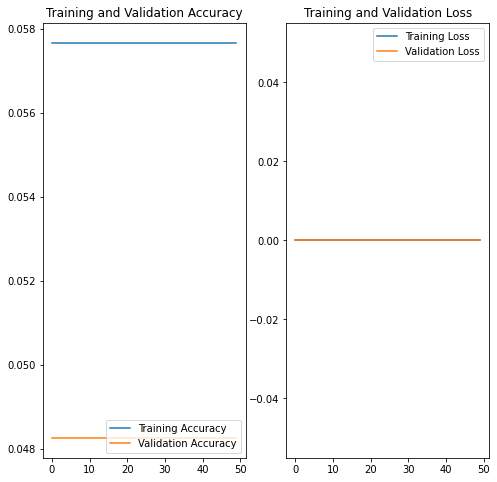

In [68]:
###Visualize the model results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Did you get rid of underfitting/overfitting? Did class rebalance help?

- The class rebalance helped in reducing overfititng of the data and thus the loass is beng reduced But it reduced the Acurracy very low

- Initially we tried without the ImageDataGenerator which created data to over fit at high ratio

- Then we introduced dropout and ImageDataGenerator which reduced the over fit

- At last we tried Batch Normalization and Augumentation which really helped in carry forward